In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from scipy.integrate import odeint

# Storage for recording values

In [2]:
# specify number of steps
ns = 100000
# define time points
t = np.linspace(0,ns/10,ns+1)
delta_t = t[1]-t[0]

n_a = 0.5
noise= (n_a)+n_a*np.sin(np.linspace(0., (ns/10000.)*np.pi, ns+1))

pv_np = np.zeros(ns+1)  # process variable
pv = torch.from_numpy(pv_np).view(ns+1, 1).type(torch.FloatTensor)

sv_np = np.zeros(ns+1)  # set point
sv_np[:25000] = 2.5         
sv_np[25001:50000] = 5.0    
sv_np[50001:75000] = 7.5    
sv_np[75001:] = 2.5         
sv = torch.from_numpy(sv_np).view(ns+1, 1).type(torch.FloatTensor)

e_np = np.zeros(ns+1)  # process variable
e = torch.from_numpy(e_np).view(ns+1, 1).type(torch.FloatTensor)

op_np = np.zeros(ns+1)  # controller output
op = torch.from_numpy(op_np).view(ns+1, 1).type(torch.FloatTensor)
nn_out_np = np.zeros(ns+1)
nn_out = torch.from_numpy(nn_out_np).view(ns+1, 1).type(torch.FloatTensor)

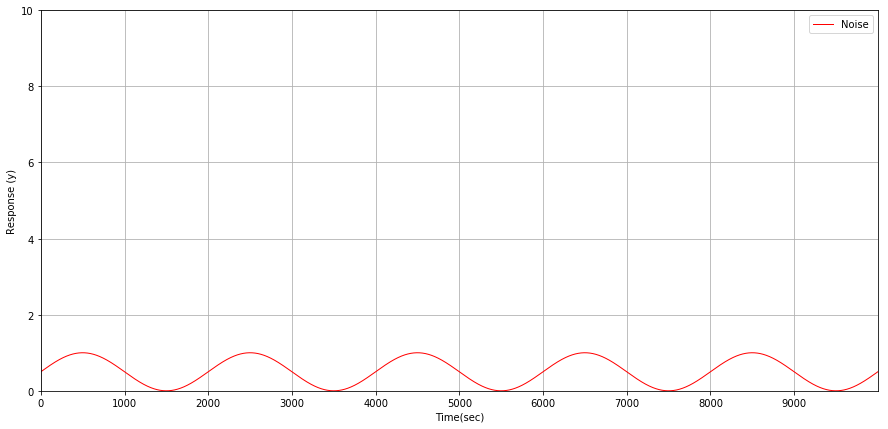

In [4]:
plt.figure(figsize=(15, 7)) 
plt.plot(t, noise, 'r-', lw =1, label='Noise')
plt.legend(loc = 'best')
plt.xlabel('Time(sec)')
plt.ylabel('Response (y)')
plt.ylim([0, 10])
plt.xlim([0, 10000])
plt.xticks(np.arange(0, 10000, step=1000))
plt.grid()
plt.show()

In [5]:
# process model
Kp = 1.0 #原來參數：3.0；改為10.0，表示100%。
taup = 600.0 #原來參數：5.0；改為600，表示60秒。
def process(y,t,u,Kp,taup):
    # Kp = process gain
    # taup = process time constant
    dydt = -y/taup + Kp/taup * u
    return dydt

# Define NN 

In [6]:
class Net(torch.nn.Module):
    def __init__(self, i1, nn1, nn2, nn3, n_output):
    # def __init__(self, i1, nn1, nn2, n_output):
        super(Net, self).__init__()
        self.a1 = torch.nn.Linear(i1, nn1)
        self.bbb = torch.nn.Linear(nn1, nn2)
        self.ccc = torch.nn.Linear(nn2, nn3)
        self.dd = torch.nn.Linear(nn3, n_output)
        # self.cc = torch.nn.Linear(nn2, n_output)
    
    def forward(self, x):
        x = torch.sigmoid(self.a1(x))  #relu
        x = torch.sigmoid(self.bbb(x)) #relu
        x = torch.sigmoid(self.ccc(x)) #relu
        x = self.dd(x)
        # x = self.cc(x)
        return x

In [7]:
net = Net(i1=1, nn1=20, nn2=20, nn3=20, n_output=1)

In [8]:
net

Net(
  (a1): Linear(in_features=1, out_features=20, bias=True)
  (bbb): Linear(in_features=20, out_features=20, bias=True)
  (ccc): Linear(in_features=20, out_features=20, bias=True)
  (dd): Linear(in_features=20, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.010) #lr=0.025

In [10]:
loss_func = torch.nn.MSELoss()

# Use the NN to control

https://www.dropbox.com/s/ziwium315jjxlda/NN-control%20picture.jpg?dl=0

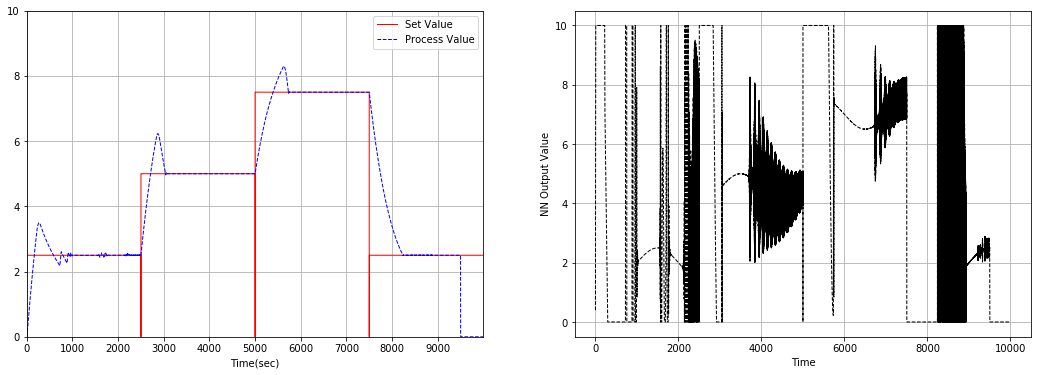

t= 9500.0  SV= 2.5000  PV= 2.5000  nn_out= 2.5189


In [11]:
op_hi = 10.0
op_lo = 0.0
for i in range(0,ns):
    e[i] = sv[i] - pv[i]  # setValue - processValue
    prediction = net(e[i]) # NN(input = e) = prediction
    op_np[i] = prediction.data.numpy()
    
    if op_np[i] > op_hi:  # check upper limit
        op_np[i] = op_hi
        
    if op_np[i] < op_lo:  # check lower limit
        op_np[i] = op_lo
           
    y_np = odeint(process,pv_np[i],[0,delta_t],args=(op_np[i]+noise[i],Kp,taup))
    prediction.data = torch.from_numpy(y_np[-1]).type(torch.FloatTensor) # y = NNOut+noise 送入 process 之 output
    loss = loss_func(prediction, sv[i])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pv_np[i+1] = y_np[-1]
    pv[i+1] = torch.from_numpy(y_np[-1])
    if i%2000 == 0:
        # draw process control performance
        display.clear_output(wait=True)
        plt.figure(figsize=(18,6))
        plt.subplot(1, 2, 1) # 1 row * 2columns
        plt.plot(t, sv_np, 'r-', lw =1, label='Set Value')
        plt.plot(t, pv_np, 'b--', lw =1, label='Process Value')
        plt.legend(loc = 'best')
        plt.xlabel('Time(sec)')
        plt.ylim([0, 10])
        plt.xlim([0, 10000])
        plt.xticks(np.arange(0, 10000, step=1000))
        plt.grid()
        
        plt.subplot(1, 2, 2) 
        plt.plot(t, op_np, 'k--', lw =1)
        plt.xlabel('Time')
        plt.ylabel('NN Output Value')
        #plt.ylim([0, 10])
        #plt.xlim([0, 10000])
        plt.grid(True)
        
        plt.pause(0.1)
        print("t={0:7.1f}  SV={1:>7.4f}  PV={2:>7.4f}  nn_out={3:7.4f}".format(i/10, sv_np[i], pv_np[i], op_np[i]))

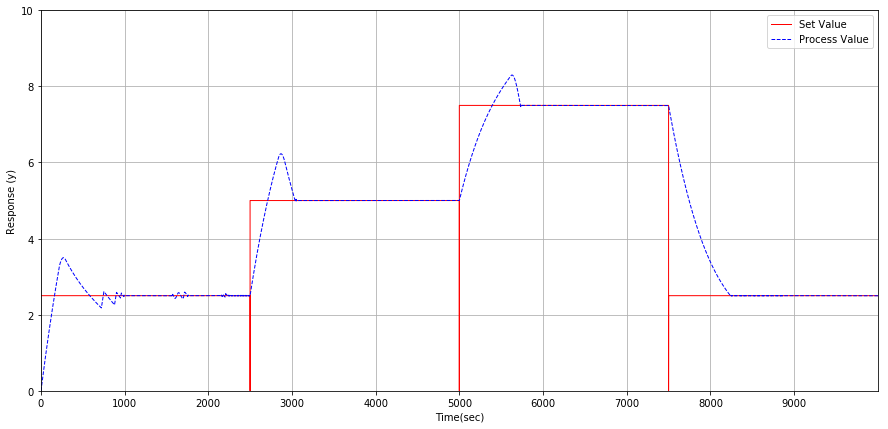

In [12]:
plt.figure(figsize=(15, 7)) 
plt.plot(t, sv_np, 'r-', lw =1, label='Set Value')
plt.plot(t, pv_np, 'b--', lw =1, label='Process Value')
plt.legend(loc = 'best')
plt.xlabel('Time(sec)')
plt.ylabel('Response (y)')
plt.ylim([0, 10])
plt.xlim([0, 10000])
plt.xticks(np.arange(0, 10000, step=1000))
plt.grid(True)
plt.show()

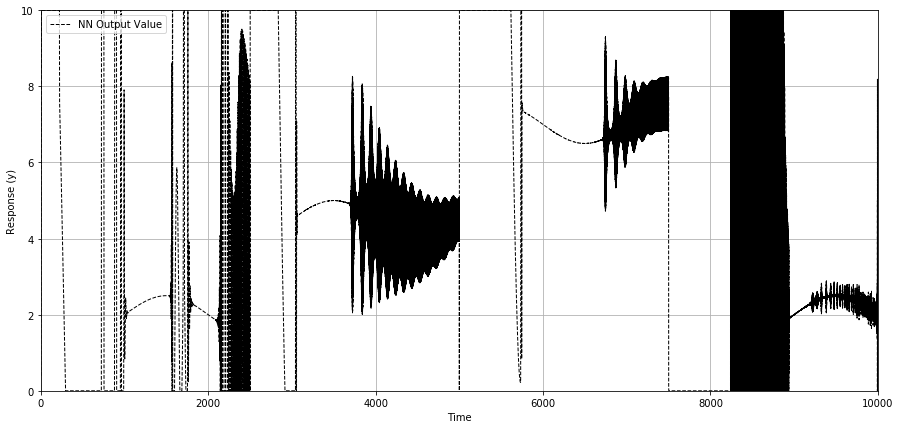

In [13]:
plt.figure(3)
plt.figure(figsize=(15, 7)) # set the figure size to 18 x 9 inches
plt.plot(t, op_np, 'k--', lw =1, label='NN Output Value')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.ylim([0, 10])
plt.xlim([0, 10000])
plt.grid(True)
plt.show()